In [16]:
import numpy as np
import os
os.chdir('/home/yunwei/SNAIL/transmon/monte_carlo/new/full_simulation')
import matplotlib.pyplot as plt
from scipy import stats
import colorednoise as cn
import qutip as qt
from noise_generator import GenerateNoise
from hamiltonian_generator import Hamiltonian
from system import *
from joblib import Parallel, delayed
from scipy.optimize import curve_fit
import numpy as np

In [17]:
class Simulation:
    def __init__(self, A, initial_state, t_max, sample_rate, num_realizations, S0):
        self.A = A
        self.initial_state = initial_state
        
        # System parameters
        self.phi_ex = 0.2
        self.Ej = 30.19 
        self.Ec = 0.1

        # Setup Hamiltonian for optimal frequency calculation
        self.sc = Hamiltonian(self.phi_ex, self.Ej, self.Ec, [5,3])
        self.optimal_omega,rate = self.sc.optimal_omegad(self.A)
        self.optimal_omega = self.optimal_omega*2*np.pi
        self.sc = Hamiltonian(self.phi_ex, self.Ej, self.Ec, [3,2]) 
        self.sample_rate = sample_rate
        self.num_realizations = num_realizations
        self.S0 = S0
        self.t_max = t_max
        self.cplus_state, self.kick_and_sigmax, self.get_projector = self.sc.setup_floquet_system(A,self.optimal_omega)
        self.detuning = np.real(self.sc.H)[2,2] - self.optimal_omega

    def noise_check(self, if_plot=False):
        # Initialize arrays to store results
        tnoise_max = int(self.t_max)             # number of samples
        relative_PSD_strength = self.S0**2
        ifwhite = False               # True for white noise, False for 1/f noise
        
        gn = GenerateNoise(self.sample_rate, tnoise_max, relative_PSD_strength, self.num_realizations, ifwhite)
        trajs = gn.generate_colored_noise()
        self.trajs = trajs
        if if_plot:
            gn.analyze_noise_psd(trajs)
    
    def operators(self):
        sds = self.sc.noise
        sop = self.sc.s
        H_control = self.sc.H_control
        H0 = self.sc.H
        diagonal_energies = np.diag(self.sc.H) - self.sc.H[0,0]
        H0 = np.diag(diagonal_energies)
        sds = qt.Qobj(sds)
        sop = qt.Qobj(sop)
        H_control = qt.Qobj(H_control)
        H0 = qt.Qobj(H0)
        return sds, sop, H_control, H0,

    def I_control(self, ramp_time, T, amplitude=1.0):
        if ramp_time <= 0 or T < 2 * ramp_time:
            raise ValueError("Invalid parameters: Ensure ramp_time > 0 and T >= 2 * ramp_time")

        def pulse(t):
            t = np.asarray(t)
            result = np.zeros_like(t, dtype=float)

            # Sin-squared ramp up
            mask1 = (t > 0) & (t < ramp_time)
            result[mask1] = amplitude * np.sin((np.pi / 2) * (t[mask1] / ramp_time))**2

            # Flat top
            mask2 = (t >= ramp_time) & (t <= T - ramp_time)
            result[mask2] = amplitude

            # Sin-squared ramp down
            mask3 = (t > T - ramp_time) & (t < T)
            result[mask3] = amplitude * np.sin((np.pi / 2) * (1 - (t[mask3] - (T - ramp_time)) / ramp_time))**2

            if result.shape == ():
                return float(result)
            return result

        return pulse

    def Q_control(self, freq, ramp_time, T, amplitude=1.0):
        if ramp_time <= 0 or T < 2 * ramp_time:
            raise ValueError("Invalid parameters: Ensure ramp_time > 0 and T >= 2 * ramp_time")

        peak = amplitude * np.pi / (2 * ramp_time)

        def pulse_derivative(t):
            t = np.asarray(t)
            result = np.zeros_like(t, dtype=float)

            # Derivative of ramp up
            mask1 = (t > 0) & (t < ramp_time)
            result[mask1] = peak * np.sin(np.pi * t[mask1] / ramp_time)

            # Derivative of ramp down
            mask3 = (t > T - ramp_time) & (t < T)
            result[mask3] = -peak * np.sin(np.pi * (t[mask3] - (T - ramp_time)) / ramp_time)

            result = -result / freq

            if result.shape == ():
                return float(result)
            return result

        return pulse_derivative

    import numpy as np

    def A_function(self, freq, ramp_time, T, amplitude=1.0):
        if ramp_time <= 0 or T < 2 * ramp_time:
            raise ValueError("Invalid parameters: Ensure ramp_time > 0 and T >= 2 * ramp_time")

        deriv_peak = amplitude * np.pi / (2 * ramp_time)
        pi_over_2 = np.pi / 2
        pi_over_rt = np.pi / ramp_time
        inv_freq = 1.0 / freq

        def A(t):
            t = np.asarray(t, dtype=float)
            result = np.full_like(t, fill_value=0.0, dtype=float)

            # Use boolean masks once
            mask1 = (t > 0) & (t < ramp_time)
            mask2 = (t >= ramp_time) & (t <= T - ramp_time)
            mask3 = (t > T - ramp_time) & (t < T)

            # Ramp up calculations
            if np.any(mask1):
                ang1 = pi_over_2 * (t[mask1] / ramp_time)
                sin_ang1 = np.sin(ang1)
                I1 = amplitude * sin_ang1 * sin_ang1
                Q1 = -deriv_peak * np.sin(pi_over_rt * t[mask1]) * inv_freq
                result[mask1] = np.hypot(I1, Q1)  # More efficient for sqrt(I^2+Q^2)

            # Flat top amplitude is constant
            if np.any(mask2):
                result[mask2] = amplitude

            # Ramp down calculations
            if np.any(mask3):
                ang3 = pi_over_2 * (1 - (t[mask3] - (T - ramp_time)) / ramp_time)
                sin_ang3 = np.sin(ang3)
                I3 = amplitude * sin_ang3 * sin_ang3
                Q3 = deriv_peak * np.sin(pi_over_rt * (t[mask3] - (T - ramp_time))) * inv_freq
                result[mask3] = np.hypot(I3, Q3)

            if result.shape == ():
                return float(result)
            return result

        return A


    def phi_function(self, freq, ramp_time, T, amplitude=1.0):
        if ramp_time <= 0 or T < 2 * ramp_time:
            raise ValueError("Invalid parameters: Ensure ramp_time > 0 and T >= 2 * ramp_time")

        deriv_peak = amplitude * np.pi / (2 * ramp_time)
        pi_over_2 = np.pi / 2
        pi_over_rt = np.pi / ramp_time
        inv_freq = 1.0 / freq

        def phi(t):
            t = np.asarray(t, dtype=float)
            result = np.zeros_like(t, dtype=float)

            mask1 = (t > 0) & (t < ramp_time)
            mask2 = (t >= ramp_time) & (t <= T - ramp_time)
            mask3 = (t > T - ramp_time) & (t < T)

            # Ramp up phase
            if np.any(mask1):
                ang1 = pi_over_2 * (t[mask1] / ramp_time)
                sin_ang1 = np.sin(ang1)
                I1 = amplitude * sin_ang1 * sin_ang1
                Q1 = -deriv_peak * np.sin(pi_over_rt * t[mask1]) * inv_freq
                result[mask1] = np.arctan2(Q1, I1)

            # Plateau phase
            if np.any(mask2):
                result[mask2] = 0.0

            # Ramp down phase
            if np.any(mask3):
                ang3 = pi_over_2 * (1 - (t[mask3] - (T - ramp_time)) / ramp_time)
                sin_ang3 = np.sin(ang3)
                I3 = amplitude * sin_ang3 * sin_ang3
                Q3 = deriv_peak * np.sin(pi_over_rt * (t[mask3] - (T - ramp_time))) * inv_freq
                result[mask3] = np.arctan2(Q3, I3)

            if result.shape == ():
                return float(result)
            return result

        return phi



In [18]:
from scipy.optimize import curve_fit
import numpy as np
import warnings
from joblib import Parallel, delayed

def fit_T1_function(time_points, population_data):
    """Fits y = 1 - exp(-t/T1), returns T1."""
    def fit1(t, T1):
        return 1 - np.exp(-t / T1)
    try:
        popt, _ = curve_fit(fit1, time_points, population_data, p0=[np.median(time_points)])
        return popt[0]
    except (RuntimeError, ValueError) as e:
        warnings.warn(f"T1 fit failed: {e}")
        return np.nan

def fit_T2_function(time_points, population_data, omega):
    """Fits y = exp(-t/T2) * cos(omega*t), returns T2."""
    def T2fit(t, T2):
        return np.exp(-t / T2) * np.cos(omega * t)
    try:
        popt, _ = curve_fit(T2fit, time_points, population_data, p0=[1e6])
        return popt[0]
    except (RuntimeError, ValueError) as e:
        warnings.warn(f"T2 fit failed: {e}")
        return np.nan

def calculate_t_phi_uncertainty_via_bootstrap(
    t1_population_matrix, t1_time_points, fit_t1_func,
    t2_population_matrix, t2_time_points, fit_t2_func,
    t2_omega, num_bootstrap_samples=1000, n_jobs=-1
):
    """
    Bootstraps T1 and T2 data, computes dephasing rate 1/T_phi = 1/T2 - 1/(2*T1).
    Returns (mean_dephasing_rate, std_dephasing_rate).
    """
    num_t1_traj = t1_population_matrix.shape[0]
    num_t2_traj = t2_population_matrix.shape[0]

    def bootstrap_single(seed):
        np.random.seed(seed)

        # Bootstrap T1
        idx1 = np.random.randint(0, num_t1_traj, size=num_t1_traj)
        avg_t1 = np.mean(t1_population_matrix[idx1], axis=0)
        T1 = fit_t1_func(t1_time_points, avg_t1)

        # Bootstrap T2
        idx2 = np.random.randint(0, num_t2_traj, size=num_t2_traj)
        avg_t2 = np.mean(t2_population_matrix[idx2], axis=0)
        T2 = fit_t2_func(t2_time_points, avg_t2, t2_omega)

        if np.isnan(T1) or np.isnan(T2) or T1 <= 0 or T2 <= 0:
            return np.nan

        dephasing_rate = 1/T2 - 1/(2*T1)
        return dephasing_rate

    print(f"Starting {num_bootstrap_samples} bootstrap iterations...")
    results = Parallel(n_jobs=n_jobs)(
        delayed(bootstrap_single)(i) for i in range(num_bootstrap_samples)
    )

    valid = [r for r in results if not np.isnan(r)]
    if len(valid) < num_bootstrap_samples:
        warnings.warn(f"{num_bootstrap_samples - len(valid)} bootstrap iterations failed/discarded.")
    if not valid:
        return np.nan, np.nan

    return np.mean(valid), np.std(valid, ddof=1)


In [4]:
def run_full_simulation(A, S0):
    """Compute T1 and T2 trajectory data and save to pickle. Returns sim object for later use."""
    initial_state = []
    t_max = 100000
    num_realizations = 100
    sample_rate = 1        # per ns
    sim = Simulation(A,initial_state, t_max,sample_rate, num_realizations,S0)
    sim.noise_check()

    # ---- T1 simulation ----
    def simulate_trajectory_T1(i, sim, A, t_max, sample_rate, sim_time):
        sds, sop, H_control, H0 = sim.operators()
        time_points = np.linspace(0, sim_time, sim_time)
        floquet_states,sigmax,sigmas = sim.kick_and_sigmax(0)
        get_projector = sim.get_projector
        floquet_ground = floquet_states[:,0]
        floquet_excited = floquet_states[:,1]
        initial_state = qt.Qobj(floquet_excited)
        drive_term = lambda t, args: A * np.cos(sim.optimal_omega * t )
        opts = {'nsteps': t_max, 'atol': 1e-12, 'rtol': 1e-12}
        gamma = 1 / (2e4)
        opts = {'nsteps': sim.t_max, 'atol': 1e-12, 'rtol': 1e-12}
        c_ops = [np.sqrt(gamma) * qt.Qobj(sop)]
        traj = np.cos(sim.phi_ex*np.pi)*(np.cos(sim.trajs[i]*np.pi)-1) - np.sin(sim.phi_ex*np.pi)*np.sin(sim.trajs[i]*np.pi)
        H = [H0, [sds, lambda t, args: traj[int(t * sample_rate)] if t < t_max else 0],[H_control, drive_term]]
        result = qt.mesolve(H, initial_state, time_points, c_ops, options=opts)

        avg_values_single = np.zeros(len(time_points))
        for j, t in enumerate(time_points):
            floquet_states, sigmax, sigmas = sim.kick_and_sigmax(t)
            projectors = get_projector(floquet_states)
            P00 = projectors[0]
            avg_values_single[j] = qt.expect(P00, result.states[j])
        return avg_values_single

    t1_sim_time = 10000
    num_trajectories = len(sim.trajs)
    t1_time_points = np.linspace(0, t1_sim_time, t1_sim_time)
    avg_values = Parallel(n_jobs=-1)(
        delayed(simulate_trajectory_T1)(i, sim, A, t_max, sample_rate, t1_sim_time) 
        for i in range(num_trajectories)
    )
    avg_values_T1 = np.array(avg_values)

    # ---- T2 simulation ----
    def simulate_trajectory_T2(i, sim, A, t_max, sample_rate, sim_time):
        sds, sop, H_control, H0 = sim.operators()
        time_points = np.linspace(0, sim_time, sim_time)
        floquet_states,sigmax,sigmas = sim.kick_and_sigmax(0)
        get_projector = sim.get_projector
        floquet_ground = floquet_states[:,0]
        floquet_excited = floquet_states[:,1]
        initial_state = (qt.Qobj(floquet_ground)+qt.Qobj(floquet_excited)).unit()
        drive_term = lambda t, args: A * np.cos(sim.optimal_omega * t )
        opts = {'nsteps': t_max, 'atol': 1e-12, 'rtol': 1e-12}
        gamma = 1 / (2e4)
        opts = {'nsteps': sim.t_max, 'atol': 1e-12, 'rtol': 1e-12}
        c_ops = [np.sqrt(gamma) * qt.Qobj(sop)]
        traj = np.cos(sim.phi_ex*np.pi)*(np.cos(sim.trajs[i]*np.pi)-1) - np.sin(sim.phi_ex*np.pi)*np.sin(sim.trajs[i]*np.pi)
        H = [H0, [sds, lambda t, args: traj[int(t * sample_rate)] if t < t_max else 0],[H_control, drive_term]]
        result = qt.mesolve(H, initial_state, time_points, c_ops, options=opts)

        avg_values_single = np.zeros(len(time_points))
        for j, t in enumerate(time_points):
            floquet_states, sigmax, sigmas = sim.kick_and_sigmax(t)
            avg_values_single[j] = qt.expect(qt.Qobj(sigmax), result.states[j])
        return avg_values_single

    t2_sim_time = 50000
    num_trajectories = len(sim.trajs)
    t2_time_points = np.linspace(0, t2_sim_time, t2_sim_time)
    avg_values = Parallel(n_jobs=-1)(
        delayed(simulate_trajectory_T2)(i, sim, A, t_max, sample_rate, t2_sim_time) 
        for i in range(num_trajectories)
    )
    avg_values_T2 = np.array(avg_values)

    return avg_values_T1, t1_time_points, avg_values_T2, t2_time_points, sim



In [ ]:
import pickle
from datetime import datetime

LOG_FILE = '/home/yunwei/SNAIL/transmon/monte_carlo/new/full_simulation/progress.log'
DATA_FILE = '/home/yunwei/SNAIL/transmon/monte_carlo/new/full_simulation/total_rate_raw_data.pkl'

def log(msg):
    """Print and write to log file so progress is visible from any SSH session."""
    timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    line = f"[{timestamp}] {msg}"
    print(line, flush=True)
    with open(LOG_FILE, 'a') as f:
        f.write(line + '\n')
        f.flush()

A_values = [1e-3 * 2 * np.pi, 3e-3 * 2 * np.pi, 5e-3 * 2 * np.pi]
S0_values = np.logspace(-6, -5, 5)  # 5 points from 1e-6 to 1e-5
total_tasks = len(A_values) * len(S0_values)

# Try to load existing raw data to resume
try:
    with open(DATA_FILE, 'rb') as f:
        raw_data = pickle.load(f)
    log(f"Loaded existing raw data from {DATA_FILE}")
except (FileNotFoundError, EOFError):
    raw_data = {}
    log("Starting fresh")

log(f"Total tasks: {total_tasks} ({len(A_values)} A values x {len(S0_values)} S0 values)")

# Compute T1/T2 trajectory data for each (A, S0), saving after each step
task_count = 0
for A in A_values:
    for idx, S0 in enumerate(S0_values):
        task_count += 1
        key = (A, S0)
        
        if key in raw_data:
            log(f"[{task_count}/{total_tasks}] A={A/(2*np.pi)*1e3:.1f}mHz, S0={S0:.1e}: SKIPPED (already done)")
            continue
        
        log(f"[{task_count}/{total_tasks}] A={A/(2*np.pi)*1e3:.1f}mHz, S0={S0:.1e}: RUNNING T1 + T2 simulation...")
        avg_values_T1, t1_time_points, avg_values_T2, t2_time_points, sim = run_full_simulation(A, S0)
        
        # Store raw trajectory data + fit_omega for bootstrap later
        raw_data[key] = {
            'avg_values_T1': avg_values_T1,
            't1_time_points': t1_time_points,
            'avg_values_T2': avg_values_T2,
            't2_time_points': t2_time_points,
            'fit_omega': sim.sc.fit_omega,
        }
        log(f"[{task_count}/{total_tasks}] A={A/(2*np.pi)*1e3:.1f}mHz, S0={S0:.1e}: DONE (T1 shape={avg_values_T1.shape}, T2 shape={avg_values_T2.shape})")
        
        # Save after each computation
        with open(DATA_FILE, 'wb') as f:
            pickle.dump(raw_data, f)
        log(f"  -> Saved raw data to {DATA_FILE}")

log("=== ALL T1/T2 SIMULATIONS DONE ===")

[2026-02-11 11:01:40] Loaded existing raw data from /home/yunwei/SNAIL/transmon/monte_carlo/new/full_simulation/total_rate_raw_data.pkl
[2026-02-11 11:01:40] Total tasks: 15 (3 A values x 5 S0 values)
[2026-02-11 11:01:40] [1/15] A=1.0mHz, S0=1.0e-06: SKIPPED (already done)
[2026-02-11 11:01:40] [2/15] A=1.0mHz, S0=1.8e-06: SKIPPED (already done)
[2026-02-11 11:01:40] [3/15] A=1.0mHz, S0=3.2e-06: SKIPPED (already done)
[2026-02-11 11:01:40] [4/15] A=1.0mHz, S0=5.6e-06: SKIPPED (already done)
[2026-02-11 11:01:40] [5/15] A=1.0mHz, S0=1.0e-05: SKIPPED (already done)
[2026-02-11 11:01:40] [6/15] A=3.0mHz, S0=1.0e-06: SKIPPED (already done)
[2026-02-11 11:01:40] [7/15] A=3.0mHz, S0=1.8e-06: SKIPPED (already done)
[2026-02-11 11:01:40] [8/15] A=3.0mHz, S0=3.2e-06: SKIPPED (already done)
[2026-02-11 11:01:40] [9/15] A=3.0mHz, S0=5.6e-06: SKIPPED (already done)
[2026-02-11 11:01:40] [10/15] A=3.0mHz, S0=1.0e-05: SKIPPED (already done)
[2026-02-11 11:01:40] [11/15] A=5.0mHz, S0=1.0e-06: SKIPPE

Starting 1000 bootstrap iterations...
A=1.0mHz, S0=1.0e-06: avg=4.696379e-08, std=2.598066e-10
Starting 1000 bootstrap iterations...
A=1.0mHz, S0=1.8e-06: avg=5.795361e-08, std=7.922817e-10
Starting 1000 bootstrap iterations...
A=1.0mHz, S0=3.2e-06: avg=8.713666e-08, std=2.193888e-09
Starting 1000 bootstrap iterations...
A=1.0mHz, S0=5.6e-06: avg=1.896056e-07, std=5.924820e-09
Starting 1000 bootstrap iterations...
A=1.0mHz, S0=1.0e-05: avg=5.440322e-07, std=2.099055e-08
Starting 1000 bootstrap iterations...
A=3.0mHz, S0=1.0e-06: avg=6.866021e-08, std=1.994481e-10
Starting 1000 bootstrap iterations...
A=3.0mHz, S0=1.8e-06: avg=7.941133e-08, std=7.319199e-10
Starting 1000 bootstrap iterations...
A=3.0mHz, S0=3.2e-06: avg=1.123959e-07, std=2.324211e-09
Starting 1000 bootstrap iterations...
A=3.0mHz, S0=5.6e-06: avg=2.192358e-07, std=7.319312e-09
Starting 1000 bootstrap iterations...
A=3.0mHz, S0=1.0e-05: avg=5.374604e-07, std=1.995671e-08
Starting 1000 bootstrap iterations...
A=5.0mHz, S0

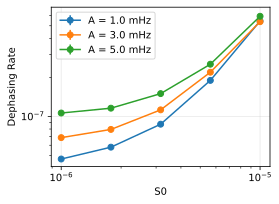

In [ ]:
# Load raw T1/T2 data, run bootstrap, and plot
import pickle
import numpy as np
import matplotlib.pyplot as plt

DATA_FILE = '/home/yunwei/SNAIL/transmon/monte_carlo/new/full_simulation/total_rate_raw_data.pkl'

with open(DATA_FILE, 'rb') as f:
    raw_data = pickle.load(f)

A_values = [1e-3 * 2 * np.pi, 3e-3 * 2 * np.pi, 5e-3 * 2 * np.pi]
S0_values = np.logspace(-6, -5, 5)

# Run bootstrap on each (A, S0)
results = {}
for A in A_values:
    results[A] = {'avg': [], 'std': []}
    for S0 in S0_values:
        key = (A, S0)
        if key not in raw_data:
            continue
        d = raw_data[key]
        avg, std = calculate_t_phi_uncertainty_via_bootstrap(
            d['avg_values_T1'], d['t1_time_points'], fit_T1_function,
            d['avg_values_T2'], d['t2_time_points'], fit_T2_function,
            d['fit_omega']
        )
        results[A]['avg'].append(avg)
        results[A]['std'].append(std)
        print(f"A={A/(2*np.pi)*1e3:.1f}mHz, S0={S0:.1e}: avg={avg:.6e}, std={std:.6e}")




In [20]:
with open('total_rate.pkl', 'wb') as f:
    pickle.dump({'A_values': A_values, 'S0_values': S0_values, 'results': results}, f)

print("Bootstrap results saved to total_rate.pkl")

Bootstrap results saved to total_rate.pkl


In [ ]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

with open('total_rate.pkl', 'rb') as f:
    data = pickle.load(f)

A_values = data['A_values']
S0_values = data['S0_values']
results = data['results']

fig, ax = plt.subplots(1, 1, figsize=(4, 3))
for A in A_values:
    if not results[A]['avg']:
        continue
    avg_vals = np.array(results[A]['avg'])
    std_vals = np.array(results[A]['std'])
    ax.errorbar(S0_values[:len(avg_vals)], avg_vals, yerr=std_vals,
                marker='o', label=f'A = {A/(2*np.pi)*1e3:.1f} mHz')

ax.set_xlabel('S0')
ax.set_ylabel('Dephasing Rate')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()